### Use K-Means to plan a vacation

I was going for a vacation to Goa for 7 days and wanted to plan my travel accordingly. I wanted to plan my travel in a way so I can cover all the places to visit and finish it in time. So I though of building a list of best tourist attractions of goa and build a solution which can suggest from where to start and which places (nearby) to cover in a day. For that I thought of using the clustering algorithm (k-Means).



#### Data

First challenge was to gather data. For that I used the tourist map published by Goa tourism in form of Google map.
https://www.google.com/maps/d/u/0/viewer?ll=15.655477560814901%2C74.04035815712655&spn=0.005871%2C0.007274&hl=en&t=m&msa=0&z=9&source=embed&ie=UTF8&mid=1LGbERKxYJJTdBzWSxG_MWS2IBLw

In this map there were lot of information about each of the 72 best places Goa tourism suggest it self. I wanted my algorithm to work on the latitude and longitude to identify the closest places as possible to each other. To extract this information from this file and convert it to a numpy array I used following approach.

1. downloaded the map as kml file.
2. open that kml file in notepad and save it as xml file (Goa.xml).

Then I used a the xml parser to parse this file


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as Soup

In [93]:
#open the xml file with utf8 encoding as you will find many utf encoded character in the xml file

with open('Goa.xml',encoding="utf8") as Goa_data:
    parsed_data = Soup(Goa_data, 'lxml-xml') # Parse as XML

## now parse the file and gather each coordinates for each entry in the file and store it in the list
lat_long = parsed_data.find_all('coordinates')
coordinates_list = []

for x in lat_long:
    coordinates_list.append(str(x)) 
    
## do similarly with the names of places in the xml file
names = parsed_data.find_all('name') 
names_list = []
for x in names:
    names_list.append(str(x)) # store the coordinates in a list
    


In [94]:
# now we will create a data frames from these lists

df_colomns = ['Long', 'Lat', 'Place']
places_df = pd.DataFrame(columns=df_colomns) 

# Now we will split the coordinamtes list into latitude and longitudes separated by ',' and also add name to it
# First two entry of names are some non relevant values, so start range from 3rd entry
for i, j in zip(range(len(coordinates_list)), range(2, len(names_list))):
    item = coordinates_list[i]
    splt_str = item.split(',')
    long = float(splt_str[0][26:]) # used to remove the leading text 
    let = float(splt_str[1])
    place = names_list[j][6:-7] # used to remove the leading and trailing text

    places_df.loc[i] = [long, let, place]

In [95]:
places_df.head(5)

,Long,Lat,Place
0,73.703220,15.684671,Arambol Beach
1,73.713005,15.657544,Mandrem Beach
2,73.716588,15.646697,Ashvem Beach
3,73.736329,15.615680,Morgim Beach
4,73.733518,15.602660,Vagator Beach


#### Plot the places

Now let us plot the places in the form of graph

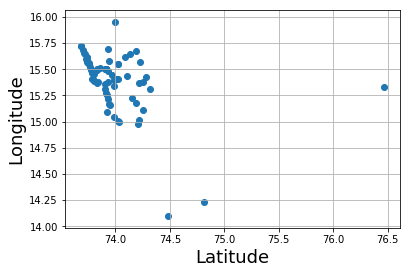

In [96]:
plt.scatter(places_df['Long'], places_df['Lat']            )
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.grid()
plt.show()

it shows that most of the places are near and there are 2 - 3 far places as well

## Model - k-Means 

In [120]:
from sklearn.cluster import KMeans 

# we will tune our model to create 7 cluster, one for each day of travel

goa_cluster = KMeans(n_clusters=7)

# We will only use latitude and longitudes to fit the data. 
data  = places_df[['Long','Lat']].values

predict = goa_cluster.fit_predict(data)

In [121]:
print (predict)

[0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 1 1 1 1 1 1 0 3 3 3 3 3 3 3 3 3 3 1 4 6 4
 0 3 0 0 6 6 6 3 1 1 4 6 6 3 1 6 5 5 2 4 4 0 3 3 0 1 4 3 3 3 3 3 1 3 6]


In [122]:
## concatenate these predictions as a new column in original data representing each day
day_df = pd.concat([places_df.reset_index(), 
                       pd.DataFrame({'day':predict})], 
                      axis=1)
# after concatination drom the first duplicate index
day_df.drop('index', axis=1, inplace=True)

In [123]:
day_df.head()

,Long,Lat,Place,day
0,73.703220,15.684671,Arambol Beach,0
1,73.713005,15.657544,Mandrem Beach,0
2,73.716588,15.646697,Ashvem Beach,0
3,73.736329,15.615680,Morgim Beach,0
4,73.733518,15.602660,Vagator Beach,0


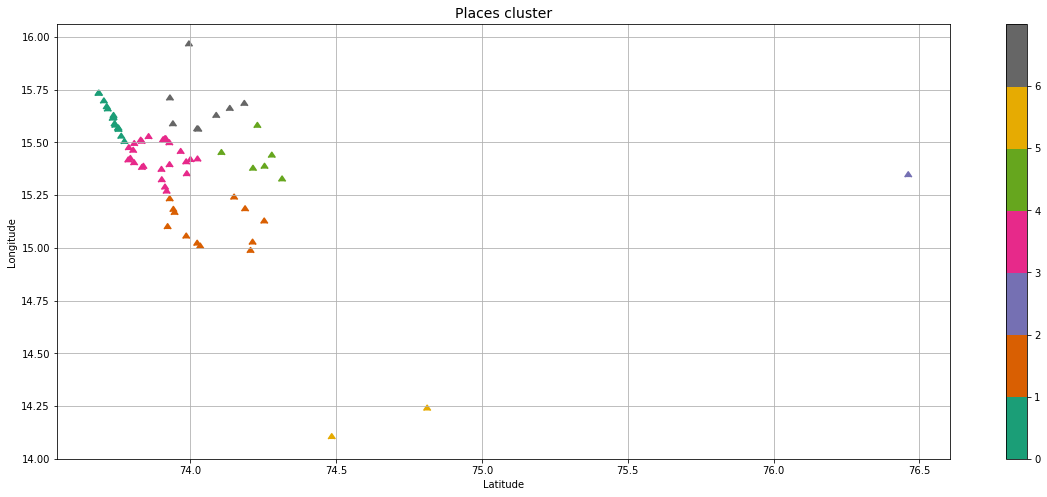

In [124]:
fig = plt.figure(figsize=(20,8))
cmap=plt.cm.Dark2
norm = matplotlib.colors.BoundaryNorm(np.arange(0,8,1), cmap.N)
plt.scatter(day_df['Long'], day_df['Lat'], c=day_df['day'] , cmap=cmap, marker = 10, norm=norm, s=50, edgecolor='none')

plt.colorbar(ticks=np.linspace(0,6,7))
plt.xlabel('Latitude', fontsize=10)
plt.ylabel('Longitude', fontsize=10)
plt.title('Places cluster', fontsize=14)
plt.grid()
plt.show()

so we can see that here 2 days reserved by algorithm for two point in the bottom and one in the far. If we feel these points are too far and are outliers we can remove then and then rest of the close by places can be divide in 7 days. let them draw it on google map to see how far it is actually

### Let us plot on google map

We will use gmplot library for the same. it will draw a graph on the google map which will be saved in the form of TravelMap.html in the same path where this notebook is saved.


In [125]:
# import gmplot package 
import gmplot 
  
# GoogleMapPlotter return Map object 
# Pass the center latitude and 
# center longitude 
gmap1 = gmplot.GoogleMapPlotter( 15.374774, 73.838768,10)

colormap = ['red','blue','green','black','cyan','magenta','brown']
for i in range(0, len(day_df)):
    lat = [0]
    long = [0]
    colorv =[0]
    lat [0]= day_df.Lat[i]
    long [0]= day_df.Long[i]
    colorv = colormap[day_df.day[i]]
   
    gmap1.scatter( lat, long, color = colorv, 
                              size = 1500 , marker= False ) 

gmap1.draw("TravelMap.html")

## Refine your data

I realized that three points are actually out of Goa border and need to spend 2 days and lot of travel to cover them. So I decided to leave them and rearrange my travel so I can have two more days to cover the nearby places. So now I have 7 days to cover rest of the near places and will replan my trip.

In [126]:
# check what is the status of different values in data 
s = day_df['day'].value_counts()
print(s)

3    28
0    15
1    12
6     8
4     6
5     2
2     1
Name: day, dtype: int64


so we can say that for two days i.e. 1 and 2 only 3 places to visit which are the outliers for us. So we will remove them one by one.

In [127]:
# here I will remove the two least frequest day values (1, 2) from my dataset so that I can remove hte outliers

# we will run this loop as need to run the loop twice to remove two least frequent values of day column
for i in range (2) :
    s = day_df['day'].value_counts() 
    to_remove = s[s == s.min()].index.values # for minimum freqent value capture the corresponding day
    day_df = day_df[day_df.day != to_remove[0]] ## remove that day entry from the day column

# reassign the original df from temp df
day_df_new = day_df
s = day_df_new['day'].value_counts()
s


3    28
0    15
1    12
6     8
4     6
Name: day, dtype: int64

In [128]:
# drop the day column
day_df_new.drop(['day'],axis = 1, inplace = True)


In [130]:
places_df = day_df_new
places_df.head()

,Long,Lat,Place
0,73.703220,15.684671,Arambol Beach
1,73.713005,15.657544,Mandrem Beach
2,73.716588,15.646697,Ashvem Beach
3,73.736329,15.615680,Morgim Beach
4,73.733518,15.602660,Vagator Beach


In [131]:
goa_cluster = KMeans(n_clusters=7)

# We will only use latitude and longitudes to fit the data. 
data  = places_df[['Long','Lat']].values

predict = goa_cluster.fit_predict(data)

In [132]:
## concatenate these predictions as a new column in original data representing each day
day_df = pd.concat([places_df.reset_index(), 
                       pd.DataFrame({'day':predict})], 
                      axis=1)
# after concatination drom the first duplicate index
day_df.drop('index', axis=1, inplace=True)
day_df.head(5)

,Long,Lat,Place,day
0,73.703220,15.684671,Arambol Beach,5
1,73.713005,15.657544,Mandrem Beach,5
2,73.716588,15.646697,Ashvem Beach,5
3,73.736329,15.615680,Morgim Beach,5
4,73.733518,15.602660,Vagator Beach,5


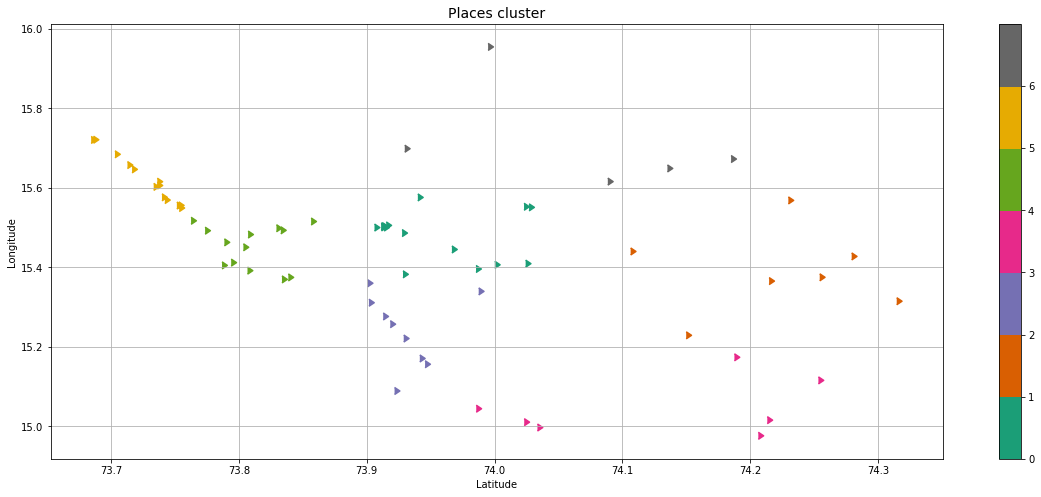

In [140]:
fig = plt.figure(figsize=(20,8))
cmap=plt.cm.Dark2
norm = matplotlib.colors.BoundaryNorm(np.arange(0,8,1), cmap.N)
plt.scatter(day_df['Long'], day_df['Lat'], c=day_df['day'] , cmap=cmap, marker = 9, norm=norm, s=50, edgecolor='none')

plt.colorbar(ticks=np.linspace(0,6,7))
plt.xlabel('Latitude', fontsize=10)
plt.ylabel('Longitude', fontsize=10)
plt.title('Places cluster', fontsize=14)
plt.grid()
plt.show()

In [141]:
#put on google map
# import gmplot package 
import gmplot 
  
# GoogleMapPlotter return Map object 
# Pass the center latitude and 
# center longitude 
gmap1 = gmplot.GoogleMapPlotter( 15.374774, 73.838768,10)

colormap = ['red','blue','green','black','cyan','magenta','brown']
for i in range(0, len(day_df)):
    lat = [0]
    long = [0]
    colorv =[0]
    lat [0]= day_df.Lat[i]
    long [0]= day_df.Long[i]
    colorv = colormap[day_df.day[i]]
   
    gmap1.scatter( lat, long, color = colorv, 
                              size = 1500 , marker= False ) 

gmap1.draw("TravelMap_new.html")

So here we are with our clustering and map. We can improve it with HDBSCAN clustering further. or can build customize routes and travel plan on the basis of user preferences.